# Сборный проект №2

#  Анализ пользовательского поведения в мобильном приложении

Цель работы - необходимо разобраться как ведут себя пользователи мобильного приложения для продажи продуктов питания. 
Следует изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, и сколько — «застревает» на предыдущих шагах. На каких именно?
Далее необходимо исследовать результаты A/A/B-эксперимента, так как дизайнеры захотели поменять шрифты во всём приложении.


# Описание данных

Данные в проекте описывают действия пользователей мобильного приложения продуктов питания.

Основные задачи:

1. Изучить воронку продаж;
2. Узнать, как пользователи доходят до покупки;
3. Выяснить, сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах;
4. Исследовать результаты A/A/B-эксперимента, где пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми;
5. Выяснить, какой шрифт лучше;

Каждая запись в логе — это действие пользователя, или событие.

* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Откроем файл с данными и изучим общую информацию

In [1]:
# импортируем все необходимые библиотеки:

import pandas as pd
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
import scipy.stats as st
import math as mth
import plotly.express as px 

In [2]:
# Прочитаем данные файла

#pd.set_option('display.max_colwidth', None)
data = pd.read_csv(r'E:\Analytics\logs_exp.csv', sep='\t')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Анализируя исходные данные, видим, что следует изменить имена столбцов и изменить тип данных времени события.

## Подготовим данные к работе

### Заменим названия столбцов на удобные для нас

In [4]:
# Приведем имена столбцов к нижнему регистру и добавим пробелы:

data = data.rename(columns={'EventName':'event_name', 'DeviceIDHash':'user_id', 'EventTimestamp':'timestamp', 'ExpId':'exp_id'})
data.head()

,event_name,user_id,timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Проверим пропуски и типы данных

In [5]:
# Проверим на пропуски:

data.isna().sum()

event_name    0
user_id       0
timestamp     0
exp_id        0
dtype: int64

Пропусков нет

In [6]:
# Проверим на явные дубликаты:
data.duplicated().sum()

413

413 явных дубликата - это менее 1 % данных, можем удалить:

In [7]:
data = data.drop_duplicates()
data.duplicated().sum()

0

От явных дубликатов избавились.
Далее необходимо откорректировать тип данных в столбце времени события:

In [8]:
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')

In [9]:
data.head()

,event_name,user_id,timestamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


### Добавим столбец даты и времени, а также отдельный столбец дат;

In [10]:
# По условию задания необходимо добавить столбец с датой и временем. Столбец с такими данными уже есть в таблице. Но  - надо, так надо...
data['date_time'] = data['timestamp']

In [11]:
# Столбец с датой:
data['date'] = data['timestamp'].dt.date
data.head()

,event_name,user_id,timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25 11:48:42,2019-07-25


## Изучим и проверим данные

### Сколько всего событий в логе?

In [12]:
# Посмотрим, какие события есть в логе и сколько их:
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

5 событий, которые заносятся в метрику.

In [13]:
# Посмотрим сколько всего событий в таблице:
ev_q = data['event_name'].count()
display(f'В логе {(ev_q)} событий')

'В логе 243713 событий'

In [14]:
# Интересно, как много каждого из событий из списка выше в таблице:
events = data.pivot_table(index='event_name', values ='date_time', aggfunc='count')
events.columns=['events_qty']
events = events.sort_values('events_qty', ascending=False).reset_index()
events.style.highlight_max(color='yellowgreen', subset=['events_qty']).highlight_min(color='coral', subset=['events_qty'])

,event_name,events_qty
0,MainScreenAppear,119101
1,OffersScreenAppear,46808
2,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


Событие "MainScreenAppear" появляется чаще всего. Реже всего - "Tutorial".

### Сколько всего пользователей в логе?

In [15]:
us_n = data['user_id'].nunique()
us_n

7551

 В таблице отражены данные о 7551 пользователе.

Согласно теории А/В тестов - для корректиности теста необходимо, чтобы количество пользователей в каждой группе было одинковым. Проверим наши данные на данный аспект:

In [17]:
user_sh = data.pivot_table(index = 'exp_id', values = 'user_id', aggfunc = 'nunique')
user_sh.columns=['user_qty']
user_sh = user_sh.sort_values(by = 'user_qty', ascending=False).reset_index()
user_sh.style.highlight_max(color='yellowgreen', subset=['user_qty']).highlight_min(color='coral', subset=['user_qty'])

,exp_id,user_qty
0,248,2542
1,247,2520
2,246,2489


Пользователи распределены по группам неравномерно.

Также, для корректности А/В теста необходимо, чтобы каждый пользователь состоял только в одной группе. Проверим:

In [18]:
test_group = data.pivot_table(index='user_id', values='exp_id', aggfunc='nunique')
test_group.columns = ['events']
test_group.sort_values(by ='events',ascending = False)
test_group.head()

,events
user_id,
6888746892508752,1
6909561520679493,1
6922444491712477,1
7435777799948366,1
7702139951469979,1


Каждый пользователь состоит только в одной группе.

### Сколько в среднем событий приходится на пользователя?

In [19]:
# Сперва сформируем таблицу с id пользователей и количеством событий на каждого:

events_per_user = data.pivot_table(index='user_id', values='event_name', aggfunc = 'count')
events_per_user.columns = ['event_qty']
events_per_user = events_per_user.sort_values('event_qty', ascending=False).reset_index()
events_per_user

,user_id,event_qty
0,6304868067479728361,2307
1,197027893265565660,1998
2,4623191541214045580,1768
3,6932517045703054087,1439
4,1754140665440434215,1221
...,...,...
7546,7399061063341528729,1
7547,2968164493349205501,1
7548,8071397669512236988,1
7549,425817683219936619,1


In [24]:
# Среднее количество событий на пользователя:

events_per_user['event_qty'].mean()

32.27559263673685

В среднем, на пользователя приходится 32 события, хотя есть и рекордсмены с числом событий около 2000.

Если построить гистограмму числа событий на одного пользователя и проанализировать ее на выбросы, то можно определить, что лучше использовать, среднее или медиану.

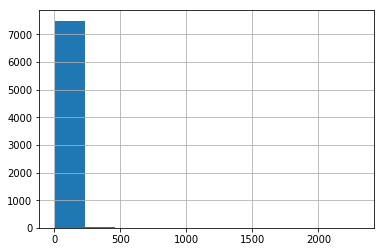

In [25]:
events_per_user['event_qty'].hist()

По гистограмме видно, что для расчета среднего количества событий на пользователя корректнее использовать медиану:

In [27]:
events_per_user['event_qty'].median()

20.0

По медиане в среднем, на пользователя приходится 20 событий.

###  Изучим период времени, данными о котором мы располагаем. Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени

In [28]:
data['date_time'].min()

Timestamp('2019-07-25 04:43:36')

In [29]:
data['date_time'].max()

Timestamp('2019-08-07 21:15:17')

В исходной таблице отражены данные с 25 июля 2019 года по 7 августа 2019 года. 

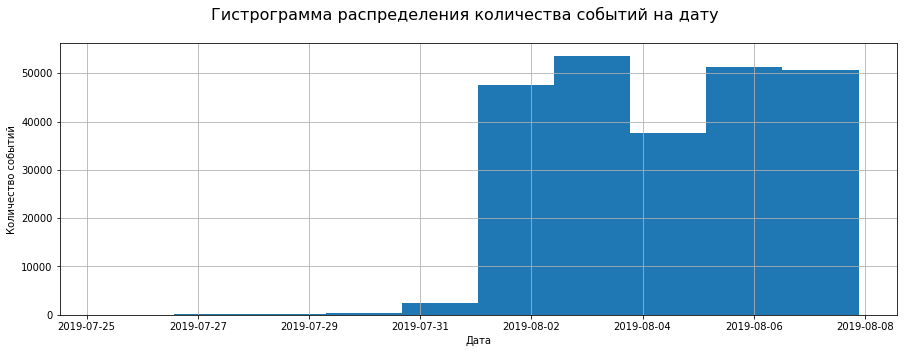

In [30]:
# Гистограмма по дате и времени:

plt.figure(figsize=(15, 5))
data['date_time'].hist()
plt.suptitle('Гистрограмма распределения количества событий на дату', fontsize= 16) 
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

По гистограмме видим, что данные за весь период непольные. Только начиная с 1 августа данных достаточно много. Решаем отбросить данные за даты ранее 1 августа. Таким образом, мы располагаем данными с 1 по 7 августа.

In [31]:
# Обновим таблицу с учетом уточненных дат:
data['date'] = pd.to_datetime(data['date'])
data_new = data[data['date']>='2019-08-01'] 

### Оценим, как много данных (событий и пользователей) мы потеряли, отбросив старые данные

In [32]:
# Посмотрим сколько всего событий в таблице:
ev_q_new = data_new['event_name'].count()
display(f'В логе после фильтра {(ev_q_new)} событий')

'В логе после фильтра 240887 событий'

In [33]:
# Оценка количества пользователей после фильтра по дате:

user_number_new = data_new['user_id'].nunique()
user_number_new

7534

In [34]:
display(f'После применения фильтра по дате было потеряно {(ev_q_new/ev_q)} событий, что составляет {(round(100-(ev_q_new*100/ev_q),2))} % событий')
display(f'После применения фильтра по дате было потеряно {(user_number_new/us_n)}, что составляет {(round(100-(user_number_new*100/us_n),2))} % пользователей')


'После применения фильтра по дате было потеряно 0.988404393692581 событий, что составляет 1.16 % событий'

'После применения фильтра по дате было потеряно 0.9977486425638988, что составляет 0.23 % пользователей'

Потери назначительные.

### Проверим, что у нас есть пользователи из всех трёх экспериментальных групп

In [35]:
user_sh_new = data_new.pivot_table(index = 'exp_id', values = 'user_id', aggfunc = 'nunique')
user_sh_new.columns=['user_qty']
user_sh_new = user_sh_new.sort_values('user_qty', ascending=False).reset_index()
user_sh_new.style.highlight_max(color='yellowgreen', subset=['user_qty']).highlight_min(color='coral', subset=['user_qty'])

,exp_id,user_qty
0,248,2537
1,247,2513
2,246,2484


Во всех трех группах пользователи есть.

## Изучим воронку событий

### Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте

In [36]:
# Сведем таблицу из обновленных данных:
events_new = data_new.pivot_table(index='event_name', values ='date_time', aggfunc='count')
events_new.columns=['events_qty']
events_new = events_new.sort_values('events_qty', ascending=False).reset_index()
events_new.style.highlight_max(color='yellowgreen', subset=['events_qty']).highlight_min(color='coral', subset=['events_qty'])

,event_name,events_qty
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


По-прежнему событие "MainScreenAppear" появляется чаще всего. Реже всего - "Tutorial".

### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие. 

In [37]:
# Сведем таблицу из обновленных данных:
user_events = data_new.pivot_table(index='event_name', values ='user_id', aggfunc='nunique')
user_events.columns=['user_qty']
user_events = user_events.sort_values('user_qty', ascending=False).reset_index()
user_events.style.highlight_max(color='yellowgreen', subset=['user_qty']).highlight_min(color='coral', subset=['user_qty'])

,event_name,user_qty
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Теперь расчитаем долю пользователей, которые хоть раз совершали событие:

In [38]:
user_events['user_share'] = round((user_events['user_qty']/user_number_new*100),2)
user_events

,event_name,user_qty,user_share
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Почти каждый пользователь видел главный экран, до корзины добрались меньше половины пользователей.

### Сделаем предположение, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Не будем учитывать их при расчёте воронки

Поскольку, мы работаем в интерент-магазине по продаже продуктов питания, пользователи становятся нашими клиентами по-разному: есть "органики" - тогда они в первую очередь увидят главный экран. Пользователи, зашедшие по рассылкам - погут попасть сразу на страницу предложения. Также, могут быть пользователи, которые сохранили заказ в корзине и остановились на этом шаге, и далее вернулись во вкладку Приложения сразу на страницу корзины. На экран с обучением, попадают пользователи реже всего, что объяснимо: у всех есть опыт использования приложения интернет-магазина. Всем нужен товар, обучение - нет.

Касательно последовательной цепочки: на экран с успешной оплатой нельзя попасть не оплатив заказ. Прежде, чем оплатить заказ - его нужно сформировать - это можно сделать двумя способами: накидав нужные единицы продукции в корзину, или через "быстрый заказ" на карточке товара или предложения (если такая опция есть). Главный экран и экран с предложением также участвуют в воронке продаж (для органиков - точно). Таким образрм - Обучение стоит исключить и расчетов воронки, этот экран просматривают 1/10 всех пользователей.


### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

Из таблицы с событиями уберем строку с событием "Tutorial":

In [39]:
user_events = user_events.iloc[:-1,:]
user_events
# актуальная воронка событий имеет вид:

,event_name,user_qty,user_share
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97


In [40]:
# Вычислим долю пользователей в следующем шаге относительно текущего шага:
user_events = user_events.reset_index()
user_events['user_next_step'] = round(user_events['user_qty'] / user_events['user_qty'].shift()*100,1)

# Для пользователей первого шага вычислим долю относительно общего количества пользователей:
user_events.loc[0, 'user_next_step'] = round(user_events.loc[0,'user_qty'] / user_number_new*100,1)
user_events.style.background_gradient('coolwarm', subset=['user_next_step'])

,index,event_name,user_qty,user_share,user_next_step
0,0,MainScreenAppear,7419,98.470000,98.500000
1,1,OffersScreenAppear,4593,60.960000,61.900000
2,2,CartScreenAppear,3734,49.560000,81.300000
3,3,PaymentScreenSuccessful,3539,46.970000,94.800000


Итого: от общего количества пользователей - доходят до "Главного экрана" - 98,5%. От тех, кто дошел до "Главного экрана" - доходят до экрана "Предложения" - почти 62% пользователей. От Пользователей с " Экрана Предложения" - до "Корзины" доходят 81,3% пользователей. В итоге - успешно оплативших заказ почти 95% пользователей. 

Для наглядности посторим график воронки:

In [44]:
# График воронки продаж:
df = dict(
    number=user_events['user_next_step'],
    stage=user_events['event_name'],  textinfo = '%')
fig = px.funnel(df, x='number', y='stage', title="Воронка событий", labels = True)
fig.update_xaxes(title_text='%')
fig.update_yaxes(title_text='Событие')

fig.show()

Воронка не равномерная, наглядно видно, что теряем слишком много на этапе OffersScreenAppear.

### На каком шаге теряем больше всего пользователей?

Больше всего пользователей мы теряем на шаге - "OffersScreenAppear": около 38% пользователей. 

Необходимо узнать нашу ЦА, их интересы, провести custdev, узнавать, чтобы они хотели увидеть, что надо улучшить, смотреть путь пользователя, удобство интерфейса, выдвигать гипотезы и проверять их.


### Какая доля пользователей доходит от первого события до оплаты?

In [45]:
# Посчитаем долю пользователей от первого шага до последнего:
paying_users = round(user_events.loc[3,'user_qty'] / user_events.loc[0,'user_qty'],2)*100

display(f'От первого события до успешной оплаты доходят {paying_users} % пользователей')


'От первого события до успешной оплаты доходят 48.0 % пользователей'

## Изучим результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [46]:
# Из шага 3.6 выше выведем группы и количество пользователей в каждой группе:
user_sh_new.style.highlight_max(color='yellowgreen', subset=['user_qty']).highlight_min(color='coral', subset=['user_qty'])

,exp_id,user_qty
0,248,2537
1,247,2513
2,246,2484


В контрольных группах A1 и А2 (246 и 247) —  2484 и 2513 пользователей соответственно. В экспериментальной В (248) группе — больше всего пользователей 2537.

Для удобства дальнешйих расчетов, введем новые переменные для размеров групп:

In [47]:
all_users_246 = user_sh_new.loc[2,'user_qty']
all_users_247 = user_sh_new.loc[1,'user_qty']
all_users_248 = user_sh_new.loc[0,'user_qty']
all_users_246_247 = user_sh_new.loc[1,'user_qty']+user_sh_new.loc[2,'user_qty']


In [48]:
# Посмотрим на распределение пользователей в группах по событиям:
exp_users = data_new.pivot_table(index='event_name', columns ='exp_id',values = 'user_id', aggfunc = 'nunique')
exp_users.columns=['246','247','248']
exp_users = exp_users.sort_values('246', ascending=False).reset_index()
exp_users['all_users_246'] = all_users_246
exp_users['all_users_247'] = all_users_247
exp_users['all_users_248'] = all_users_248
exp_users['all_users_246_247'] = all_users_246_247
exp_users


,event_name,246,247,248,all_users_246,all_users_247,all_users_248,all_users_246_247
0,MainScreenAppear,2450,2476,2493,2484,2513,2537,4997
1,OffersScreenAppear,1542,1520,1531,2484,2513,2537,4997
2,CartScreenAppear,1266,1238,1230,2484,2513,2537,4997
3,PaymentScreenSuccessful,1200,1158,1181,2484,2513,2537,4997
4,Tutorial,278,283,279,2484,2513,2537,4997


Посчитаем доли пользователей, переходящих на следующий шаг воронки для каждой группы:

In [49]:
exp_users['246_%'] = round(exp_users['246']/all_users_246,3)*100
exp_users['247_%'] = round(exp_users['247']/all_users_247,3)*100
exp_users['248_%'] = round(exp_users['248']/all_users_248,3)*100
exp_users['246_247'] = exp_users['246']+exp_users['247'] # количество пользователей в объединенных группах А1 и А2
exp_users

,event_name,246,247,248,all_users_246,all_users_247,all_users_248,all_users_246_247,246_%,247_%,248_%,246_247
0,MainScreenAppear,2450,2476,2493,2484,2513,2537,4997,98.6,98.5,98.3,4926
1,OffersScreenAppear,1542,1520,1531,2484,2513,2537,4997,62.1,60.5,60.3,3062
2,CartScreenAppear,1266,1238,1230,2484,2513,2537,4997,51.0,49.3,48.5,2504
3,PaymentScreenSuccessful,1200,1158,1181,2484,2513,2537,4997,48.3,46.1,46.6,2358
4,Tutorial,278,283,279,2484,2513,2537,4997,11.2,11.3,11.0,561


### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Сформулируем нулевую гипотезу: между двумя контрольными группами А1 и А2 нет статистически значимого различия.
Альтернативная гипотеза состоит в том, что между двумя контрольными группами А1 и А2 статистически значимое различие - есть. 
Проверять гипотезу будем методом А/В теста - это один из самых популярных и точных способов проверки гипотезы. 

Уровень статистической значимости α установим равным 0,05. Уровень статистической значимости — это вероятность случайно получить в реальном наблюдении значение, далёкое от предполагаемого в нулевой гипотезе.

In [50]:
def stat_test(successes, trying):
    # пропорция успехов в первой группе:
    p1 = successes[0]/trying[0]
# пропорция успехов во второй группе:
    p2 = successes[1]/trying[1]
# пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trying[0] + trying[1])
# разница пропорций в датасетах
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trying[0] + 1/trying[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    display ('p-значение: ', p_value)
    if p_value < alpha:
        display('Отвергаем нулевую гипотезу: между долями групп есть статистически значимая разница')
    else:
        display(
            'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными')
        
alpha = 0.05
for idx, event in enumerate(exp_users['event_name']):
    successes = np.array([exp_users['246'][idx], exp_users['247'][idx]])
    trying = np.array([exp_users['all_users_246'][idx], exp_users['all_users_247'][idx]])
    stat_test(successes, trying)



'p-значение: '

0.7570597232046099

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.2480954578522181

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.22883372237997213

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.11456679313141849

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.9376996189257114

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

Cтатистические критерии не находят разницу между выборками 246 и 247, группы собраны корректно.

### Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий. Можно ли сказать, что разбиение на группы работает корректно?

Очевидно, что самое популярное событие это - "MainScreenAppear".

Число пользователей и доля пользователей, совершивших это событие в каждой из групп:

In [51]:
exp_users.query('event_name=="MainScreenAppear"')

,event_name,246,247,248,all_users_246,all_users_247,all_users_248,all_users_246_247,246_%,247_%,248_%,246_247
0,MainScreenAppear,2450,2476,2493,2484,2513,2537,4997,98.6,98.5,98.3,4926


Проверим, будет ли различие между группами статистически достоверным. Ранее, мы убедились, что статистически значимого различия между группами А1 и А2 нет. Проверим группы А1 и В, А2 и В, и А1+А2 и В: 

Сформулируем нулевую гипотезу: между двумя контрольными группами А1 и А2 и эксперементальной группой В нет статистически значимого различия. А также нет статистически значимого различия между суммарной группой А1+А2 и эксперементальной группой В.

Сформулируем альтернативнную гипотезу: между двумя контрольными группами А1 и А2 и эксперементальной группой В статистически значимое различие есть. А также есть статистически значимое различие между суммарной группой А1+А2 и эксперементальной группой В. 

#### Сравнение групп А1 и В:

In [52]:
# используем написанную ранее функцию:

for idx, event in enumerate(exp_users['event_name']):
    successes = np.array([exp_users['246'][idx], exp_users['248'][idx]])
    trying = np.array([exp_users['all_users_246'][idx], exp_users['all_users_248'][idx]])
    stat_test(successes, trying)

'p-значение: '

0.2949721933554552

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.20836205402738917

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.07842923237520116

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.2122553275697796

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.8264294010087645

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

Между группами А1 и В - нет статитстически значимой разницы.

#### Сравнение групп А2 и В:

In [53]:
# используем написанную ранее функцию:

for idx, event in enumerate(exp_users['event_name']):
    successes = np.array([exp_users['247'][idx], exp_users['248'][idx]])
    trying = np.array([exp_users['all_users_247'][idx], exp_users['all_users_248'][idx]])
    stat_test(successes, trying)

'p-значение: '

0.4587053616621515

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.9197817830592261

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.5786197879539783

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.7373415053803964

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.765323922474501

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

Между группами А2 и В - нет статитстически значимой разницы.

#### Сравнение групп А1+А2 и В:

In [54]:
# используем написанную ранее функцию:

for idx, event in enumerate(exp_users['event_name']):
    successes = np.array([exp_users['246_247'][idx], exp_users['248'][idx]])
    trying = np.array([exp_users['all_users_246_247'][idx], exp_users['all_users_248'][idx]])
    stat_test(successes, trying)

'p-значение: '

0.29424526837179577

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.43425549655188256

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.18175875284404386

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.6004294282308704

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.764862472531507

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

Между группами A1 + А2 и В - нет статитстически значимой разницы.

### Выбранный уровень значимости при проверке статистических гипотез. Какой уровень значимости стоит применить? 

При расчете статистической значимости в различиях группы был принят alpha = 0.05 - критический уровень статистической значимости
(если p-value оказывается меньше этого значения - гипотеза отвергается).


Чтобы снизить вероятность ложнопозитивного результата (отвергнуте нулевые гипотезы из числа верных нулевых гипотез) при множественном тестировании гипотез, применяют разные методы корректировки уровня значимости. Воспользуемся методом  Шидака: 

Формула для расчета Уровня значимости в каждом из m сравнений:
alpha1=alpha2=...=alpha_m=1-(1-alpha)^1/m

С учетом того, что у нас 5 событий тестируются 4 раза, в нашем случае m=20. Тогда критический уровень статистической значимости согласно методу Шидака:

In [55]:
alpha_1 = 1-(1-alpha)**(1/20)
alpha_1

0.0025613787765302876

Применим полученное значение для alpha для сравнения выборок между группами 246 и 247.

In [56]:
alpha = alpha_1
for idx, event in enumerate(exp_users['event_name']):
    successes = np.array([exp_users['246'][idx], exp_users['247'][idx]])
    trying = np.array([exp_users['all_users_246'][idx], exp_users['all_users_247'][idx]])
    stat_test(successes, trying)

'p-значение: '

0.7570597232046099

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.2480954578522181

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.22883372237997213

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.11456679313141849

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

'p-значение: '

0.9376996189257114

'Не отвергаем нулевую гипотезу, нет оснований считать доли групп разными'

Результат сравнения не изменился, статистически значимых различий между группами нет.

Анализируя результаты сравнения других пар групп - видим, что величина p-value во всех расчетах в разы больше даже первоначального занчения alpha=0,05. Снижая порог статистической значимости мы не повлияем на исход сравнения. Результат будет по-прежнему положительным - Нулевая гипотеза не может быть отвергнута.  

# Выводы:

Целью работы было определение пользовательского поведения в приложении по покупке продуктов питания. В ходе исследования была изучена воронка продаж. Оказалось, что самым "популярным" шагом является появление главного экрана. Было выяснено, что от первого шага до покупки доходят всего 48% пользователей. Больше всего пользователей теряется на шаге с Предложением. При этом, из тех, кто добавил товары в карзину - почти 95% пользователей доходят до конца и производят оплату. Следует обратить внимание на шаг с Предложением и принять меры по снижению количества "потерянных" пользователей.

Далее была проведена работа по исследованию результатов A/A/B-теста: дизайнеры компании решили поменять шрифты во всем приложении. По результам исследования оказалось, что этого делать не стоит. Большая работа разных специалистов никак не скажется на прибыли компании, так как по статистике результаты в экспеременальных и контрольной группах не различаются. Изменение шрифтов нецелесообразно.